Dataset Overview

● Step: A unit of time that represents hours in the dataset. Think of this as the timestamp of the transaction (e.g. hour 1, hour 2, … hour 534, …)

● Type: The type of transaction

● Amount: The amount of money transferred

● NameOrig: The origin account name

● OldBalanceOrg: The origin accounts balance before the transaction

● NewBalanceOrg: The origin accounts balance after the transaction

● NameDest: The destination account name

● OldbalanceDest: The destination accounts balance before the transaction

● NewbalanceDest: The destination accounts balance after the transaction

● IsFlaggedFraud: A “naive” model that simply flags a transaction as fraudulent if it is greater than 200,000 (note that this currency is not USD)

● IsFraud: Was this simulated transaction actually fraudulent? In this case, we consider “fraud” to be a malicious transaction that aimed to transfer funds out of a victim’s bank account before the account owner could secure their information. 

In [2]:
# import required modules for this project

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load csv file
df = pd.read_csv('/Users/sa26/Documents/GitHub/ML_Financial_Fraud_Detection/data/raw/log.csv')

# print out the first 5 rows of data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Print out general information on this dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.shape

(6362620, 11)

In [8]:
# Print out the summary statistics (mean, median, max, min, count) of all numeric columns
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
# Fraud pattern analysis
fraud_stats = df.groupby('isFraud').agg({
    'amount': ['mean', 'median', 'max', 'min'],
    'oldbalanceOrg': ['mean', 'median'],
    'newbalanceOrig': ['mean', 'median']
})
print(fraud_stats)

               amount                               oldbalanceOrg             \
                 mean     median          max   min          mean     median   
isFraud                                                                        
0        1.781970e+05   74684.72  92445516.64  0.01  8.328287e+05   14069.00   
1        1.467967e+06  441423.44  10000000.00  0.00  1.649668e+06  438983.45   

        newbalanceOrig         
                  mean median  
isFraud                        
0        855970.228109    0.0  
1        192392.631836    0.0  


Fraudulent transactions involve larger mean/median amounts. Fraudulent accounts often start with higher mean balances. Accounts are frequently drained post-fraud (medians for newbalanceOrig is $0). Non-fraud oldBalanceOrg is heavily right-skewed. 

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Univariate Exploratory Analysis

In [9]:
# Count first letters in name columns

def count_first_letters(column):
    # Extract first letter from each entry
    first_letters = column.str[0]
    # Count occurrences of each first letter
    letter_counts = first_letters.value_counts().to_dict()
    return letter_counts

# Counts for nameDest and nameOrig
dest_counts = count_first_letters(df['nameDest'])
orig_counts = count_first_letters(df['nameOrig'])

# Print results for nameDest
print("nameDest counts:")
for letter, count in dest_counts.items():
    print(f"{count} {letter}")

# Print results for nameOrig
print("\nnameOrig counts:")
for letter, count in orig_counts.items():
    print(f"{count} {letter}")


nameDest counts:
4211125 C
2151495 M

nameOrig counts:
6362620 C


C could potentially stand for customer, while M could potentially stand for merchant

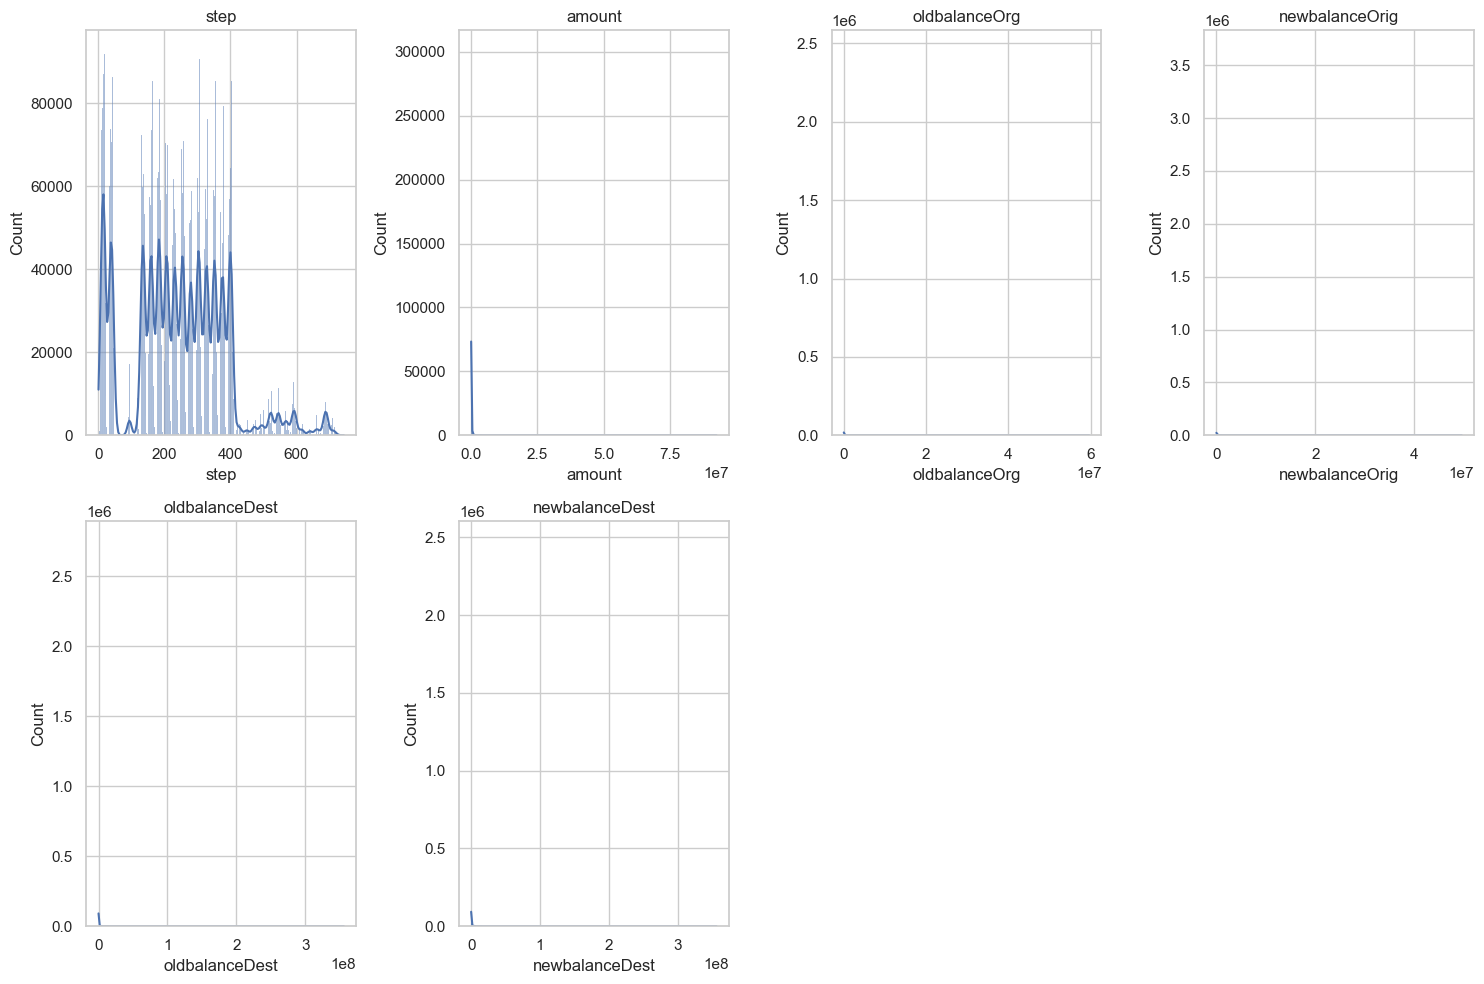

In [13]:
#Histograms
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
sns.set(style="whitegrid")

# Calculate grid dimensions based on the number of columns
num_cols = len(numeric_cols)
rows = (num_cols + 3) // 4

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

Multiple peaks for step, not as many after 400. Heavy skewness for multiple variables.

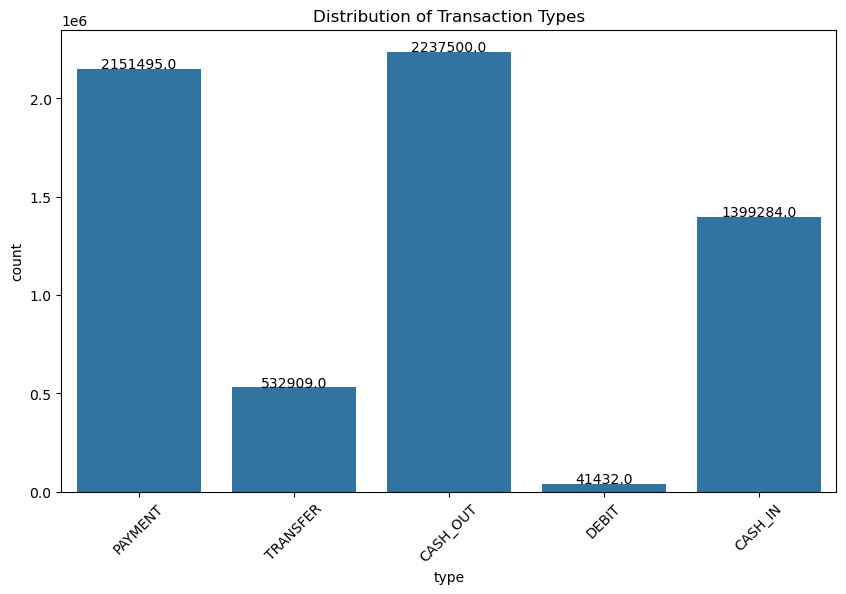

Majority of transaction types are cash_out, payment, and cash_in


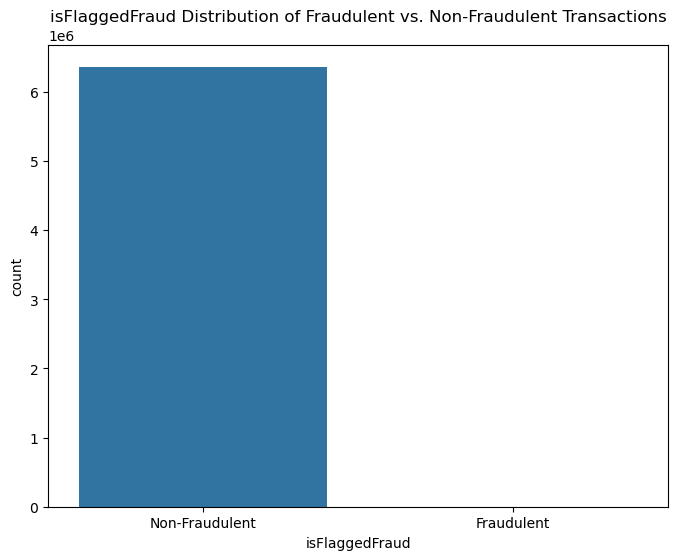

Count of isFlaggedFraud fraudulent transactions: 16
Count of correctly flagged fraudulent transactions: 16
Percentage of correctness: 100.00%


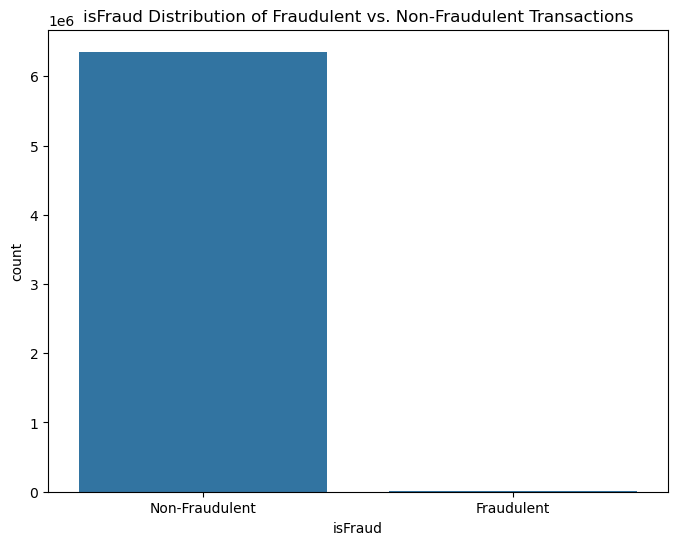

Count of isFraud fraudulent transactions: 8213


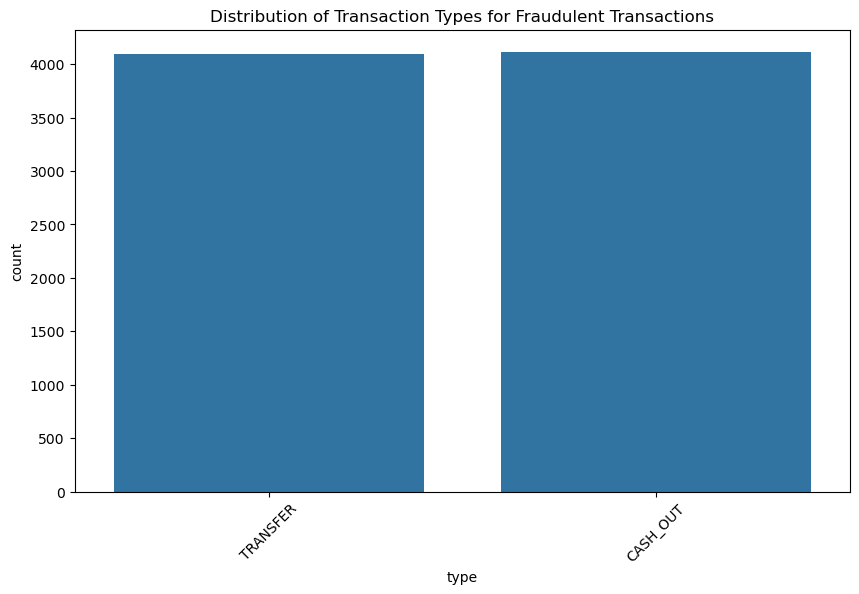

In [6]:
# Barcharts
# Transaction Type Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="type", data=df)
plt.title("Distribution of Transaction Types")
plt.xticks(rotation=45)

# Add count on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            height, ha="center")
plt.show()

print("Majority of transaction types are cash_out, payment, and cash_in")

# isFlaggedFraud Distribution

plt.figure(figsize=(8, 6))
sns.countplot(x="isFlaggedFraud", data=df)
plt.title("isFlaggedFraud Distribution of Fraudulent vs. Non-Fraudulent Transactions")
plt.xticks([0, 1], ["Non-Fraudulent", "Fraudulent"])
plt.show()

print(f"Count of isFlaggedFraud fraudulent transactions: {df[df['isFlaggedFraud'] == 1].shape[0]}")

# Calculate the count of transactions where isFlaggedFraud == 1 and isFraud == 1
correct_flagged_fraud_count = df[(df['isFlaggedFraud'] == 1) & (df['isFraud'] == 1)].shape[0]

# Calculate the total number of flagged transactions
total_flagged_fraud = df[df['isFlaggedFraud'] == 1].shape[0]

# Calculate the percentage of correctness
percentage_correct = (correct_flagged_fraud_count / total_flagged_fraud) * 100 if total_flagged_fraud > 0 else 0

# Print the results
print(f"Count of correctly flagged fraudulent transactions: {correct_flagged_fraud_count}")
print(f"Percentage of correctness: {percentage_correct:.2f}%")

# isFraud Distribution

plt.figure(figsize=(8, 6))
sns.countplot(x="isFraud", data=df)
plt.title("isFraud Distribution of Fraudulent vs. Non-Fraudulent Transactions")
plt.xticks([0, 1], ["Non-Fraudulent", "Fraudulent"])
plt.show()

print(f"Count of isFraud fraudulent transactions: {df[df['isFraud'] == 1].shape[0]}")

# Transaction Type Distribution for Fraudulent Transactions
# Filter the dataframe to show only fraudulent transactions
fraud_df = df[df["isFraud"] == 1]

plt.figure(figsize=(10, 6))
sns.countplot(x="type", data=fraud_df)
plt.title("Distribution of Transaction Types for Fraudulent Transactions")
plt.xticks(rotation=45)
plt.show()

Fraudulent Transactions fall under types transfer and cash_out

Bivariate Exploratory Analysis

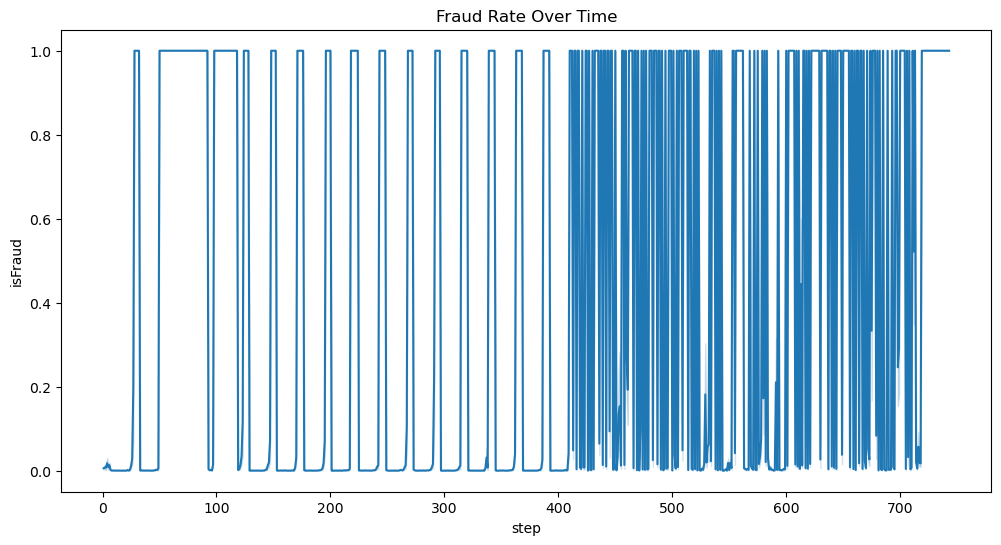

Fradulent transactions mostly after 400


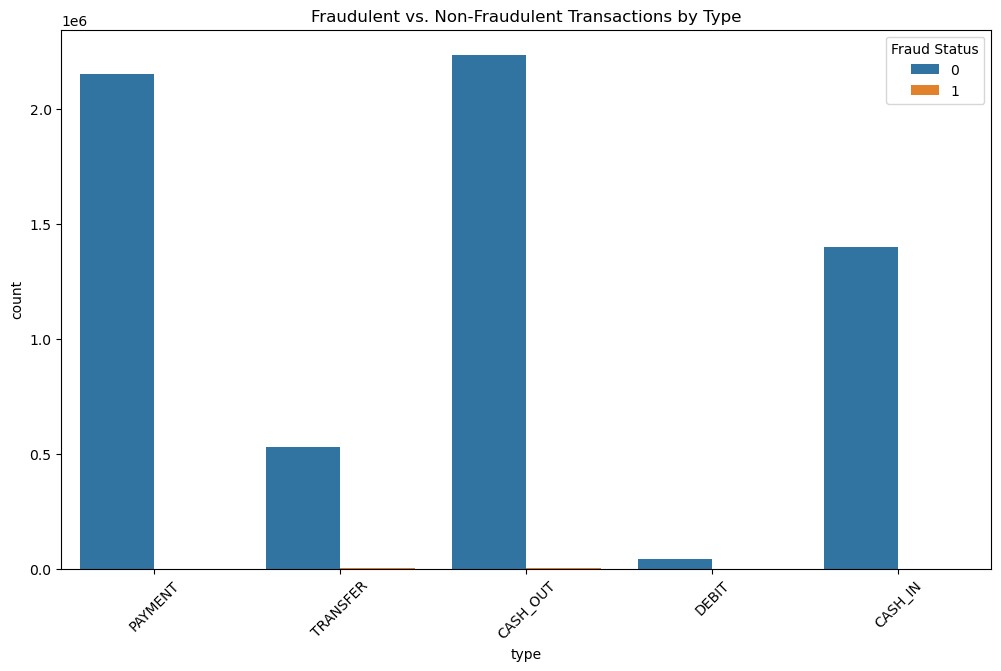

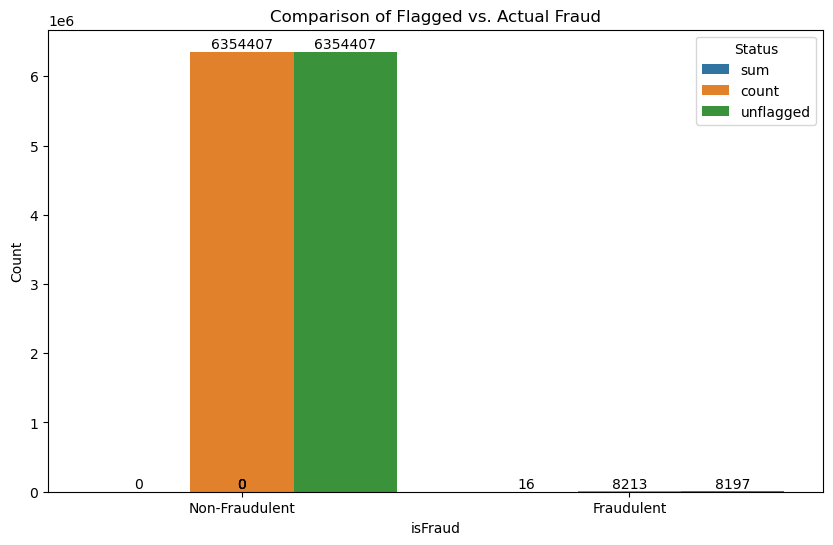

In [8]:
#Lineplot

# Temporal analysis of fraud
plt.figure(figsize=(12, 6))
sns.lineplot(x="step", y="isFraud", data=df, estimator=np.mean)
plt.title("Fraud Rate Over Time")
plt.show()

print("Fradulent transactions mostly after 400")

# Barcharts

# Fraudulent vs. Non-Fraudulent Transactions by Type
plt.figure(figsize=(12, 7))
sns.countplot(x="type", hue="isFraud", data=df)
plt.title("Fraudulent vs. Non-Fraudulent Transactions by Type")
plt.xticks(rotation=45)
plt.legend(title="Fraud Status")
plt.show()

# Flagged vs. Actual Fraud
# Create a dataframe with relevant counts
fraud_comparison = df.groupby("isFraud")["isFlaggedFraud"].agg(["sum", "count"])
fraud_comparison["unflagged"] = fraud_comparison["count"] - fraud_comparison["sum"]
fraud_comparison = fraud_comparison.reset_index()

# Melt the dataframe for plotting
melted_df = pd.melt(fraud_comparison, id_vars="isFraud", var_name="Status", value_name="Count")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="isFraud", y="Count", hue="Status", data=melted_df)

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, 
            f'{height:.0f}', ha='center', va='bottom')
plt.title("Comparison of Flagged vs. Actual Fraud")
plt.xticks([0, 1], ["Non-Fraudulent", "Fraudulent"])
plt.show()

Need for model to improve fraud detection effectiveness

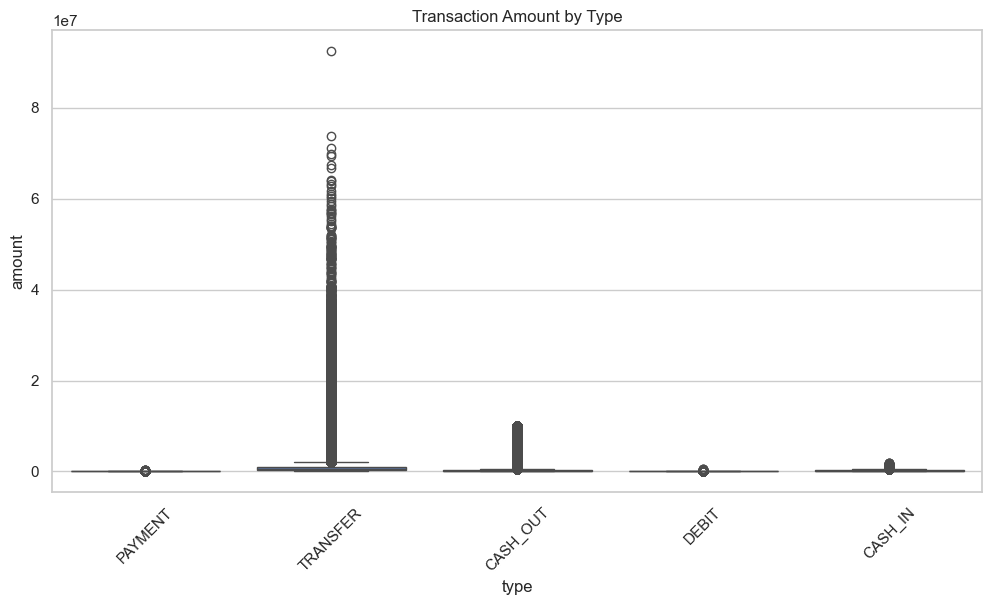

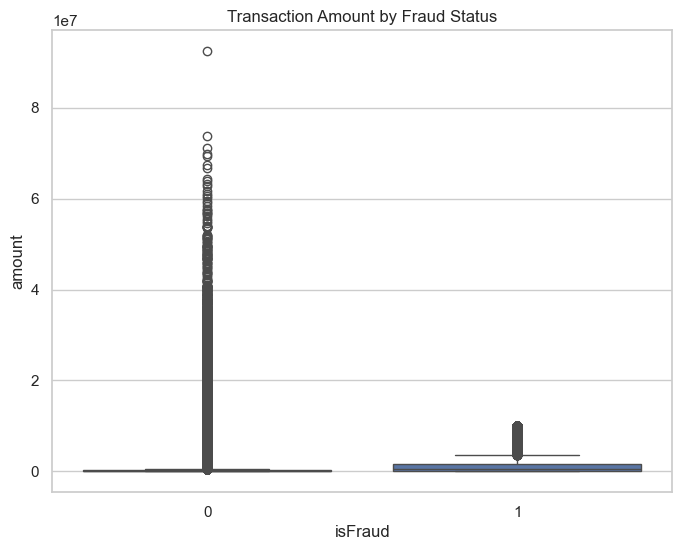

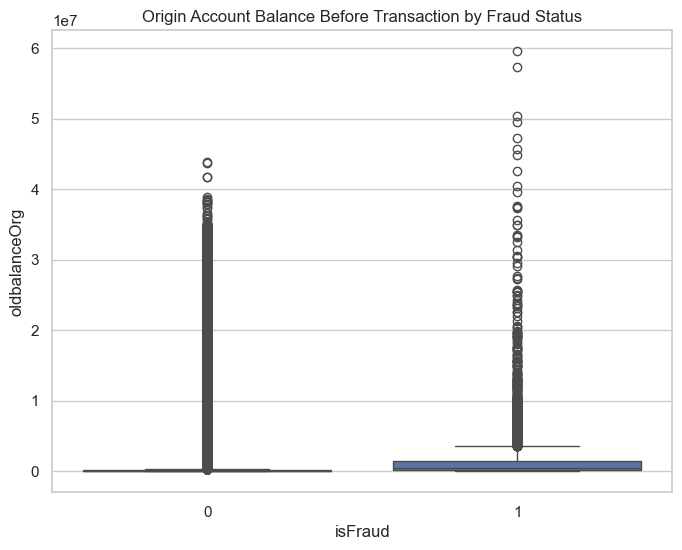

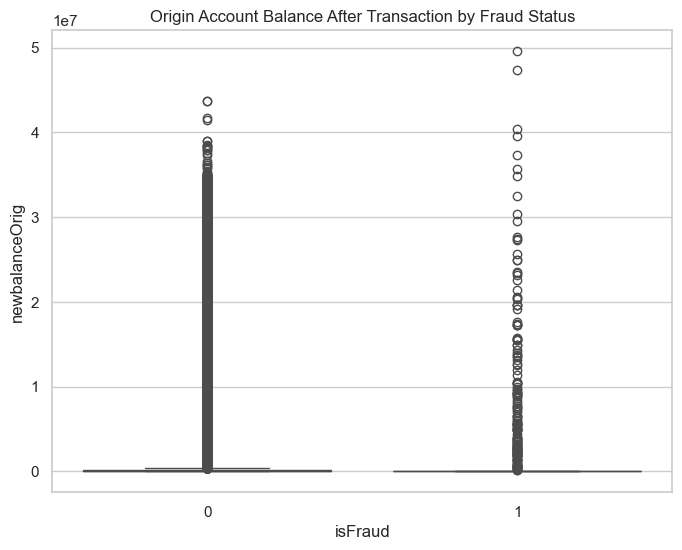

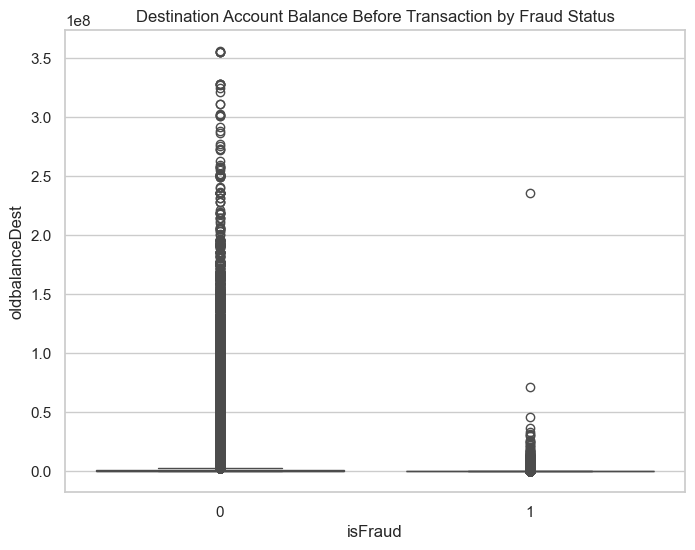

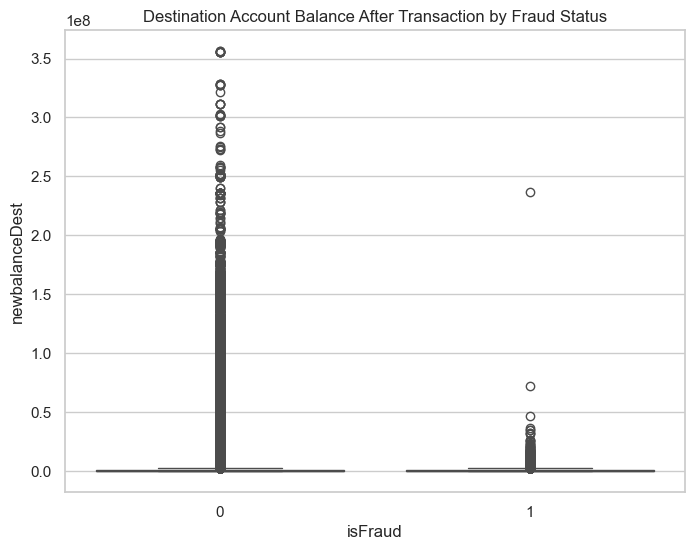

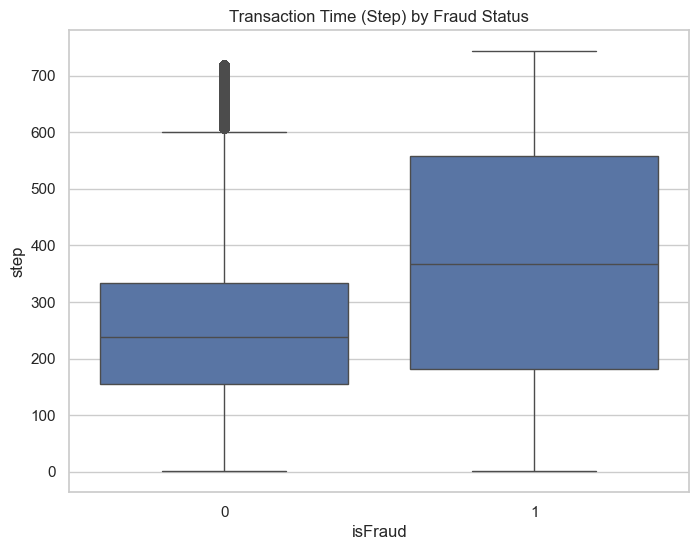

In [14]:
# Boxplots
# Set style
sns.set(style="whitegrid")

# 1. Amount vs. Type
plt.figure(figsize=(12, 6))
sns.boxplot(x="type", y="amount", data=df)
plt.title("Transaction Amount by Type")
plt.xticks(rotation=45)
plt.show()

# 2. Amount vs. IsFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Transaction Amount by Fraud Status")
plt.show()

# 3. OldBalanceOrg vs. IsFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x="isFraud", y="oldbalanceOrg", data=df)
plt.title("Origin Account Balance Before Transaction by Fraud Status")
plt.show()

# 4. NewBalanceOrig vs. IsFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x="isFraud", y="newbalanceOrig", data=df)
plt.title("Origin Account Balance After Transaction by Fraud Status")
plt.show()

# 5. OldbalanceDest vs. IsFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x="isFraud", y="oldbalanceDest", data=df)
plt.title("Destination Account Balance Before Transaction by Fraud Status")
plt.show()

# 6. NewbalanceDest vs. IsFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x="isFraud", y="newbalanceDest", data=df)
plt.title("Destination Account Balance After Transaction by Fraud Status")
plt.show()

# 7. Step vs. IsFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x="isFraud", y="step", data=df)
plt.title("Transaction Time (Step) by Fraud Status")
plt.show()

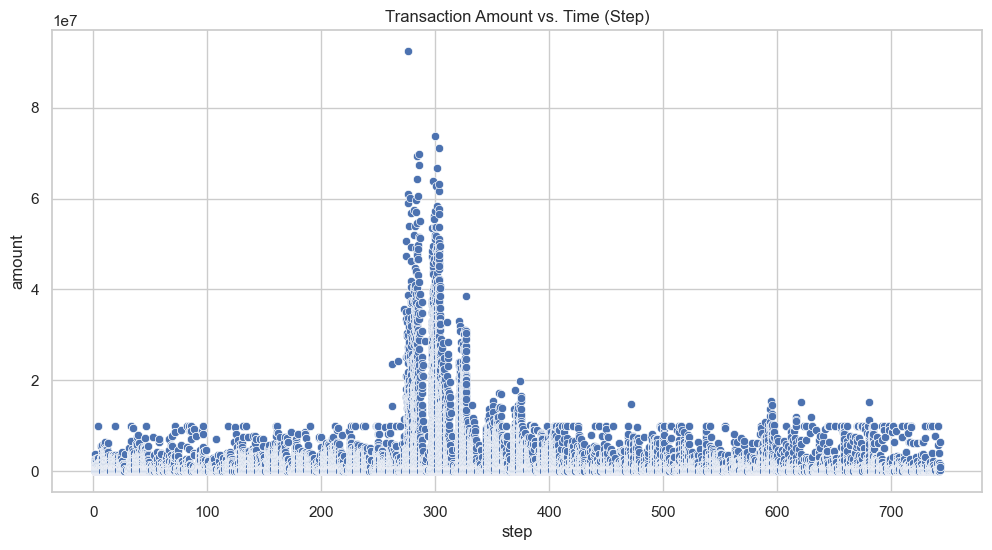

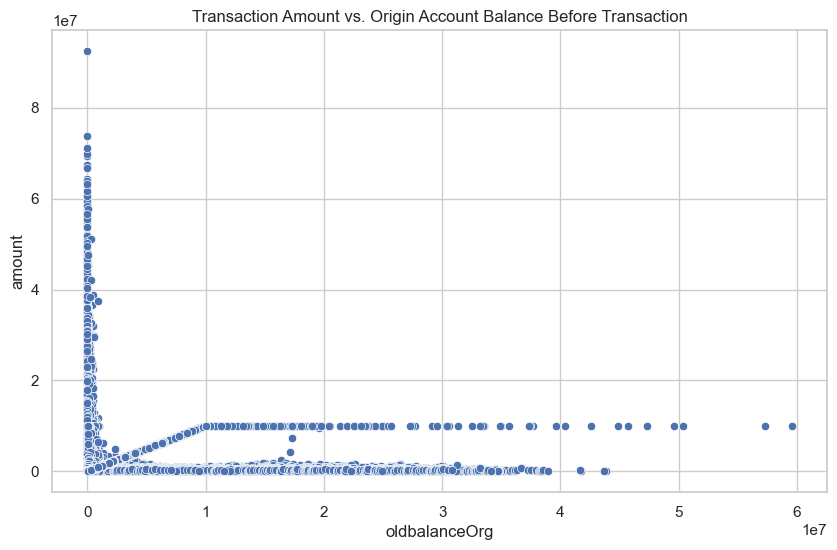

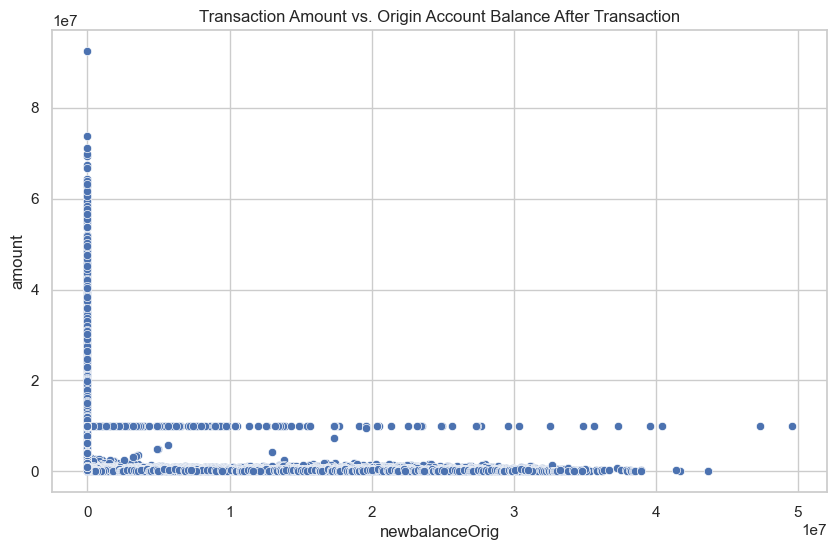

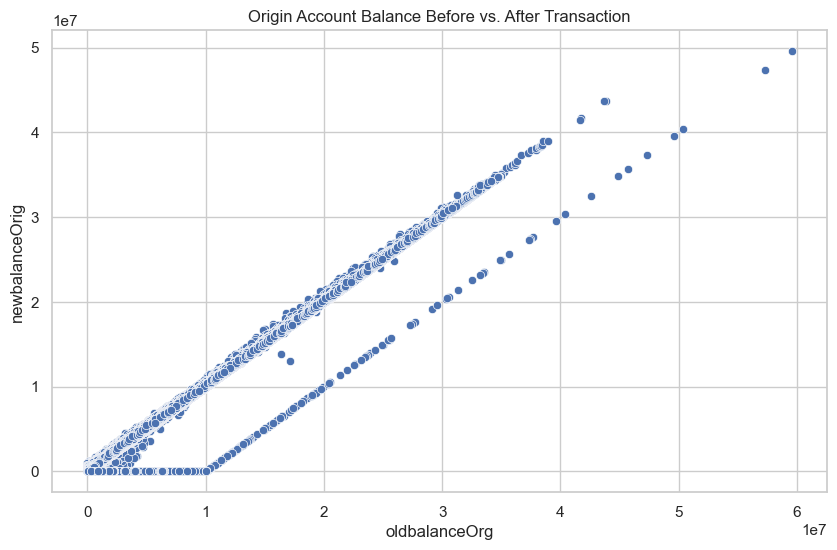

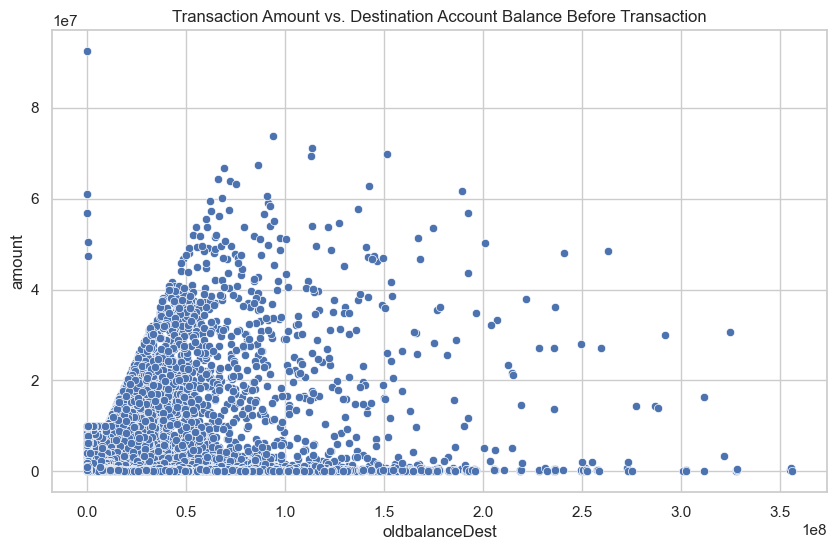

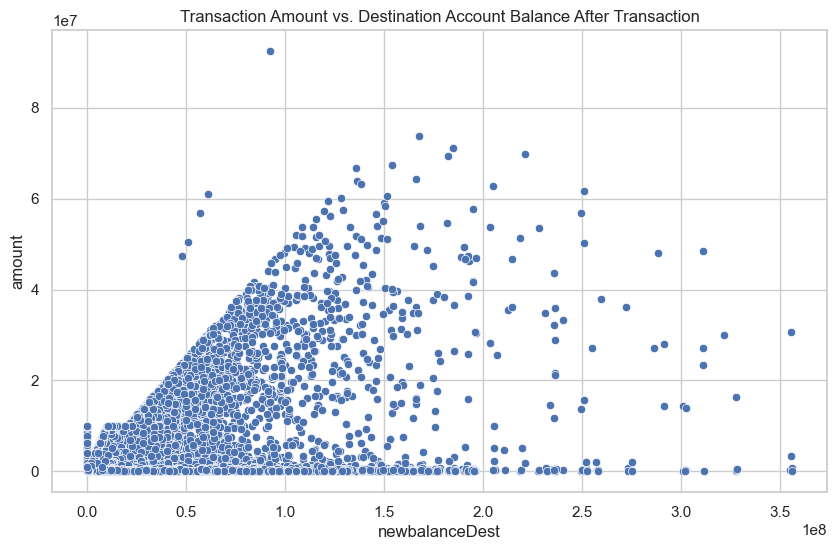

In [17]:
# Scatterplots

# Transaction Amount vs. Time (Step)
plt.figure(figsize=(12, 6))
sns.scatterplot(x="step", y="amount", data=df)
plt.title("Transaction Amount vs. Time (Step)")
plt.show()

# Transaction Amount vs. Origin Account Balance Before Transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x="oldbalanceOrg", y="amount", data=df)
plt.title("Transaction Amount vs. Origin Account Balance Before Transaction")
plt.show()

# Transaction Amount vs. Origin Account Balance After Transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x="newbalanceOrig", y="amount", data=df)
plt.title("Transaction Amount vs. Origin Account Balance After Transaction")
plt.show()

# Origin Account Balance Before vs. After Transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x="oldbalanceOrg", y="newbalanceOrig", data=df)
plt.title("Origin Account Balance Before vs. After Transaction")
plt.show()

# Transaction Amount vs. Destination Account Balance Before Transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x="oldbalanceDest", y="amount", data=df)
plt.title("Transaction Amount vs. Destination Account Balance Before Transaction")
plt.show()

# Transaction Amount vs. Destination Account Balance After Transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x="newbalanceDest", y="amount", data=df)
plt.title("Transaction Amount vs. Destination Account Balance After Transaction")
plt.show()

<Figure size 1000x600 with 0 Axes>

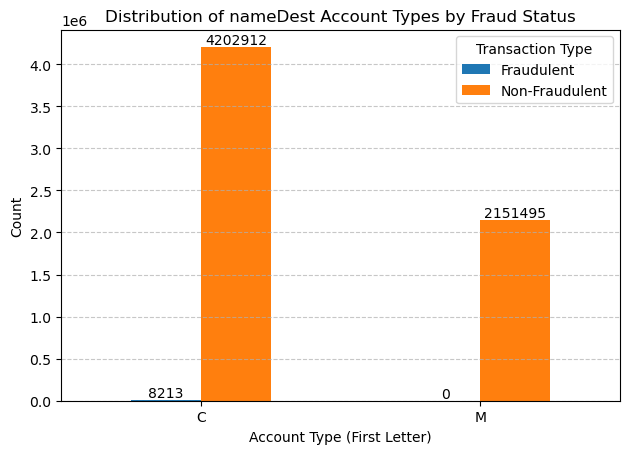

In [14]:
# Calculate counts of first letters in nameDest grouped by isFraud
fraud_counts = df[df['isFraud'] == 1]['nameDest'].str[0].value_counts()
non_fraud_counts = df[df['isFraud'] == 0]['nameDest'].str[0].value_counts()

# Combine counts into a DataFrame for plotting
plot_data = pd.DataFrame({
    'Fraudulent': fraud_counts,
    'Non-Fraudulent': non_fraud_counts
})

# Create visualization
plt.figure(figsize=(10, 6))
ax = plot_data.plot(kind='bar', stacked=False)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of nameDest Account Types by Fraud Status')
plt.xlabel('Account Type (First Letter)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Transaction Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

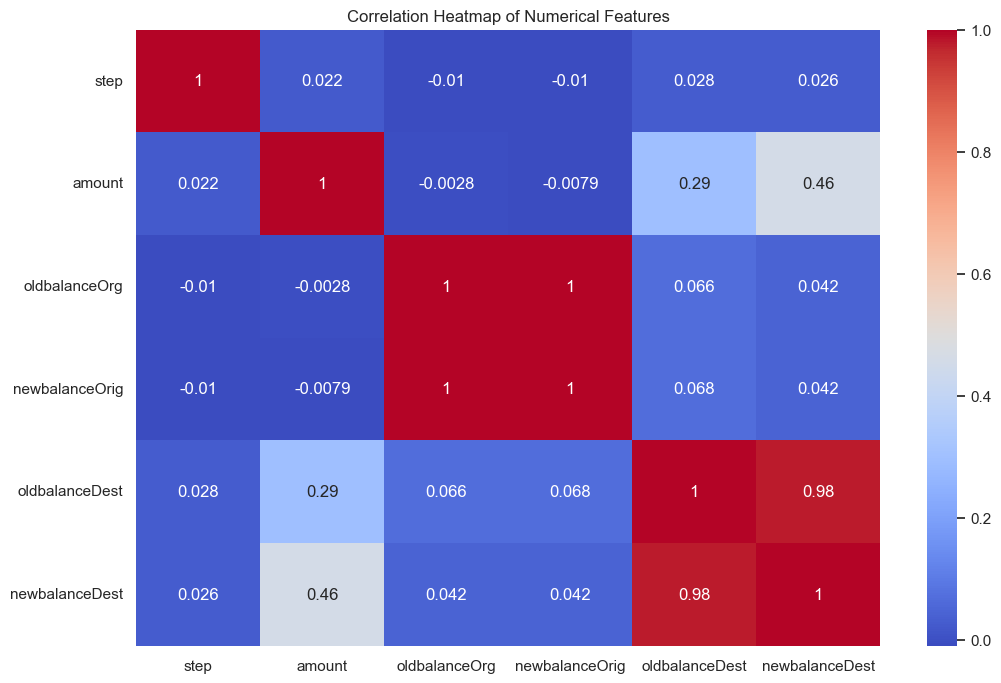

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Multivariate exploratory analysis